In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [33]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings= 768
output_dim = 3

lr = 2e-4

epochs = 50

print_step = 100

###    Step 1. Load (or download) Dataset

In [34]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def get_indices(dataset,class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
    return indices

In [5]:
from torch.utils.data import sampler

### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [35]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        return y

In [36]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [37]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [38]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity
    
    

In [39]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [40]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

Start training VQ-VAE...

            epoch: 1  step: 1  recon_loss: 0.23  perplexity: 50.93
            		commit_loss: 0.01  codebook loss: 0.03  total_loss: 0.26
            

            epoch: 1  step: 101  recon_loss: 0.04  perplexity: 56.93
            		commit_loss: 0.04  codebook loss: 0.15  total_loss: 0.22
            

            epoch: 1  step: 201  recon_loss: 0.03  perplexity: 118.13
            		commit_loss: 0.04  codebook loss: 0.14  total_loss: 0.21
            

            epoch: 1  step: 301  recon_loss: 0.02  perplexity: 194.71
            		commit_loss: 0.04  codebook loss: 0.15  total_loss: 0.21
            

            epoch: 2  step: 1  recon_loss: 0.02  perplexity: 308.07
            		commit_loss: 0.03  codebook loss: 0.12  total_loss: 0.17
            

            epoch: 2  step: 101  recon_loss: 0.02  perplexity: 395.53
            		commit_loss: 0.03  codebook loss: 0.12  total_loss: 0.17
            

            epoch: 2  step: 201  recon_loss: 0.02 


            epoch: 14  step: 101  recon_loss: 0.01  perplexity: 596.74
            		commit_loss: 0.03  codebook loss: 0.10  total_loss: 0.14
            

            epoch: 14  step: 201  recon_loss: 0.01  perplexity: 621.25
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.15
            

            epoch: 14  step: 301  recon_loss: 0.01  perplexity: 620.01
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 15  step: 1  recon_loss: 0.01  perplexity: 617.34
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 15  step: 101  recon_loss: 0.01  perplexity: 620.53
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 15  step: 201  recon_loss: 0.01  perplexity: 622.72
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.15
            

            epoch: 15  step: 301  recon_loss: 0.01  perplexity: 6


            epoch: 27  step: 201  recon_loss: 0.01  perplexity: 642.07
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.15
            

            epoch: 27  step: 301  recon_loss: 0.01  perplexity: 630.66
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 28  step: 1  recon_loss: 0.01  perplexity: 639.30
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 28  step: 101  recon_loss: 0.01  perplexity: 642.79
            		commit_loss: 0.03  codebook loss: 0.10  total_loss: 0.13
            

            epoch: 28  step: 201  recon_loss: 0.01  perplexity: 636.50
            		commit_loss: 0.03  codebook loss: 0.10  total_loss: 0.14
            

            epoch: 28  step: 301  recon_loss: 0.01  perplexity: 633.93
            		commit_loss: 0.03  codebook loss: 0.10  total_loss: 0.14
            

            epoch: 29  step: 1  recon_loss: 0.01  perplexity: 636


            epoch: 40  step: 301  recon_loss: 0.01  perplexity: 642.07
            		commit_loss: 0.03  codebook loss: 0.10  total_loss: 0.14
            

            epoch: 41  step: 1  recon_loss: 0.01  perplexity: 652.98
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 41  step: 101  recon_loss: 0.01  perplexity: 655.56
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.15
            

            epoch: 41  step: 201  recon_loss: 0.01  perplexity: 662.26
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 41  step: 301  recon_loss: 0.01  perplexity: 661.30
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 42  step: 1  recon_loss: 0.01  perplexity: 660.65
            		commit_loss: 0.03  codebook loss: 0.11  total_loss: 0.14
            

            epoch: 42  step: 101  recon_loss: 0.01  perplexity: 646

Text(0, 0.5, 'Loss')

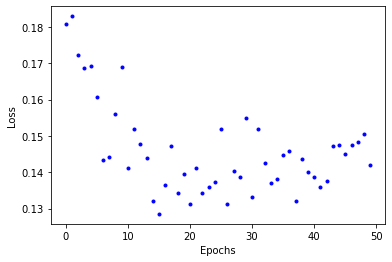

In [41]:
print("Start training VQ-VAE...")
model.train()

loss_list = []

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % print_step ==0: 
            print("""
            epoch: {}  step: {}  recon_loss: {:.2f}  perplexity: {:.2f}
            \t\tcommit_loss: {:.2f}  codebook loss: {:.2f}  total_loss: {:.2f}
            """.format(epoch + 1, batch_idx + 1, recon_loss.item(), perplexity.item(), commitment_loss.item(), codebook_loss.item(), loss.item()))
            #print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
            #  "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
    loss_list.append(loss.item()) 
print("Finish!!")
plt.plot(range(epoch+1), loss_list, 'b.')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [13]:
model_path = './models'

#torch.save(model.state_dict(), model_path)


In [15]:
model2 = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)
model2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Text(0, 0.5, 'Loss')

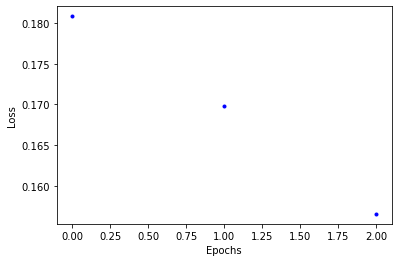

In [25]:
plt.plot(range(epoch+1), loss_list, 'b.')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Step 5. Evaluate the model

In [21]:
import matplotlib.pyplot as plt

In [22]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [124]:
#dataset = torchvision.datasets.CIFAR10(root='./data',transform=torchvision.transforms.ToTensor())
print(train_dataset.class_to_idx)
idx = get_indices(train_dataset, 8)
dog_loader = DataLoader(train_dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(idx))

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [31]:
torch.load(model_path)

OrderedDict([('encoder.strided_conv_1.weight',
              tensor([[[[ 0.0292,  0.0177,  0.0046,  0.0221],
                        [-0.0427,  0.0254, -0.1216, -0.0285],
                        [ 0.0790,  0.0773, -0.0714, -0.0711],
                        [-0.0695, -0.1430,  0.1021,  0.0114]],
              
                       [[-0.1063, -0.0387, -0.0456, -0.1027],
                        [ 0.1205, -0.0343,  0.0010,  0.0715],
                        [ 0.0461, -0.0148, -0.0665,  0.0380],
                        [-0.0461, -0.0171, -0.1029, -0.1028]],
              
                       [[-0.0586, -0.0489,  0.1430,  0.0893],
                        [ 0.0057,  0.0211, -0.0959,  0.0112],
                        [ 0.0697,  0.0928,  0.0865,  0.0158],
                        [-0.0358,  0.0325,  0.1120,  0.0997]]],
              
              
                      [[[ 0.1503, -0.0232,  0.0614,  0.0114],
                        [-0.0484, -0.0201, -0.1068, -0.0654],
                     

In [ ]:
idx = get_indices(train_dataset, 2)
bird_loader = DataLoader(train_dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(idx))


model.eval()

#with torch.no_grad():
#    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
#    generated_images = decoder(noise)
    
bird_list = []
    
for batch_idx, (x, _) in enumerate(tqdm(bird_loader)):
    
    x = x.to(DEVICE)
    
    z = encoder(x)
    
    z_quantized, commitment_loss, codebook_loss, perplexity = codebook(z)
    
    bird_list.append(z)
    
    bird_images = decoder(z_quantized)
    
    #x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
    #print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
    
birdpile = torch.stack(bird_list)
avg_bird_code = torch.mean(birdpile, dim=0)
z_quantized, _, _, _ = codebook(avg_bird_code)
avg_bird_image = decoder(z_quantized)

draw_sample_image(avg_bird_image[0], "Reconstructed images")


  6%|▋         | 322/5000 [00:46<10:24,  7.49it/s]


 13%|█▎        | 666/5000 [01:30<08:13,  8.79it/s]


 20%|██        | 1008/5000 [02:13<09:39,  6.89it/s]


 26%|██▋       | 1316/5000 [02:57<10:40,  5.75it/s]


 32%|███▏      | 1623/5000 [03:43<10:40,  5.27it/s]


 38%|███▊      | 1924/5000 [04:29<07:29,  6.84it/s]


 44%|████▍     | 2221/5000 [05:16<08:00,  5.78it/s]


 50%|█████     | 2517/5000 [06:06<07:12,  5.74it/s]


 56%|█████▋    | 2813/5000 [06:56<06:13,  5.85it/s]


 62%|██████▏   | 3109/5000 [07:52<06:34,  4.79it/s]


 69%|██████▊   | 3437/5000 [09:34<02:27, 10.57it/s]


 80%|████████  | 4004/5000 [10:26<01:20, 12.41it/s]


 89%|████████▊ | 4436/5000 [11:07<00:57,  9.88it/s]


  0%|          | 1/5000 [00:00<10:19,  8.06it/s]

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}



 12%|█▏        | 614/5000 [00:40<04:11, 17.46it/s]


 25%|██▍       | 1226/5000 [01:19<03:41, 17.02it/s]


 37%|███▋      | 1833/5000 [01:58<04:48, 10.96it/s]


 49%|████▊     | 2426/5000 [02:40<03:18, 12.98it/s]


 60%|██████    | 3011/5000 [03:27<02:40, 12.42it/s]


 72%|███████▏  | 3599/5000 [04:15<02:00, 11.62it/s]


 83%|████████▎ | 4141/5000 [05:05<01:15, 11.39it/s]


 94%|█████████▍| 4701/5000 [05:56<00:25, 11.92it/s]


100%|██████████| 5000/5000 [06:27<00:00, 12.89it/s]


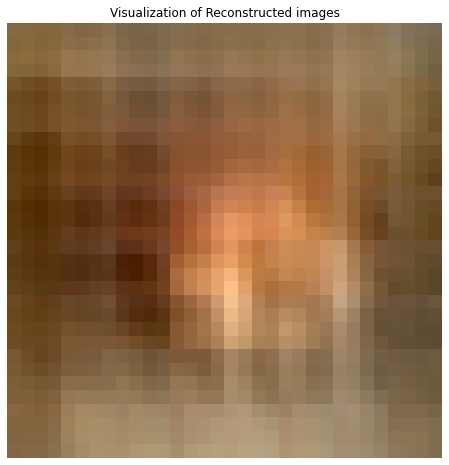

In [128]:
idx = get_indices(train_dataset, 3)
cat_loader = DataLoader(train_dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(idx))


model.eval()

#with torch.no_grad():
#    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
#    generated_images = decoder(noise)
    
cat_list = []
    
for batch_idx, (x, _) in enumerate(tqdm(cat_loader)):
    
    x = x.to(DEVICE)
    
    z = encoder(x)
    
    z_quantized, commitment_loss, codebook_loss, perplexity = codebook(z)
    
    cat_list.append(z)
    
    cat_images = decoder(z_quantized)
    
    #x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
    #print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
    
catpile = torch.stack(cat_list)
avg_cat_code = torch.mean(catpile, dim=0)
z_quantized, _, _, _ = codebook(avg_cat_code)
avg_cat_image = decoder(z_quantized)

draw_sample_image(avg_cat_image[0], "Reconstructed images")

In [125]:
model.eval()

#with torch.no_grad():
#    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
#    generated_images = decoder(noise)
    
dog_list = []
    
for batch_idx, (x, _) in enumerate(tqdm(dog_loader)):
    
    x = x.to(DEVICE)
    
    z = encoder(x)
    
    z_quantized, commitment_loss, codebook_loss, perplexity = codebook(z)
    
    dog_list.append(z)
    
    dog_images = decoder(z_quantized)
    
    #x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
    #print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
    
dogpile = torch.stack(dog_list)
avg_dog_code = torch.mean(dogpile, dim=0)
z_quantized, _, _, _ = codebook(avg_dog_code)
avg_dog_image = decoder(z_quantized)


 12%|█▏        | 602/5000 [00:41<04:19, 16.94it/s]


 24%|██▍       | 1204/5000 [01:21<03:57, 16.00it/s]


 36%|███▌      | 1796/5000 [02:03<03:45, 14.23it/s]


 48%|████▊     | 2386/5000 [02:48<03:22, 12.93it/s]


 60%|█████▉    | 2978/5000 [03:34<02:34, 13.13it/s]


 71%|███████▏  | 3569/5000 [04:24<02:13, 10.69it/s]


 82%|████████▏ | 4089/5000 [05:13<01:23, 10.93it/s]


 90%|█████████ | 4523/5000 [05:59<00:43, 11.05it/s]


 98%|█████████▊| 4897/5000 [06:42<00:14,  7.02it/s]


100%|██████████| 5000/5000 [06:55<00:00, 12.03it/s]


In [118]:
dogpile.shape

torch.Size([5000, 1, 128, 8, 8])

In [119]:
z_quantized.shape

torch.Size([1, 128, 8, 8])

In [120]:
avg_dog_code.shape

torch.Size([1, 128, 8, 8])

In [121]:
avg_dog_image.shape

torch.Size([1, 3, 32, 32])

In [98]:
print(decoder)

Decoder(
  (residual_conv_1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (residual_conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (strided_t_conv_1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (strided_t_conv_2): ConvTranspose2d(128, 3, kernel_size=(2, 2), stride=(2, 2))
)


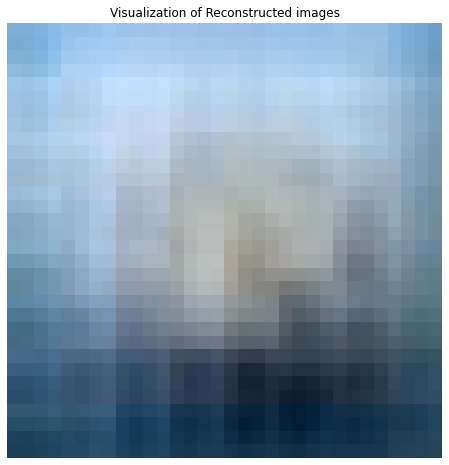

In [126]:
draw_sample_image(avg_dog_image[0], "Reconstructed images")

In [45]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|                                                                                           | 0/79 [00:01<?, ?it/s]

perplexity:  660.27392578125 commit_loss:  0.02677178755402565   codebook loss:  0.1070871502161026


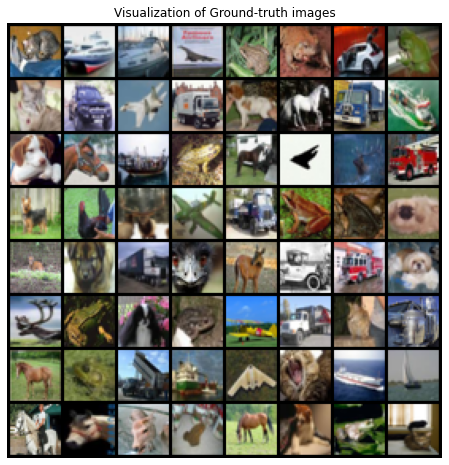

In [43]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

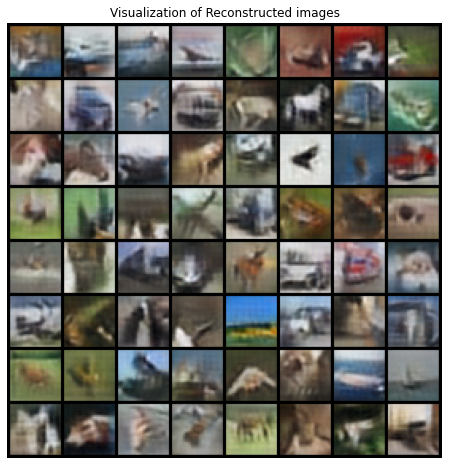

In [44]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [16]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

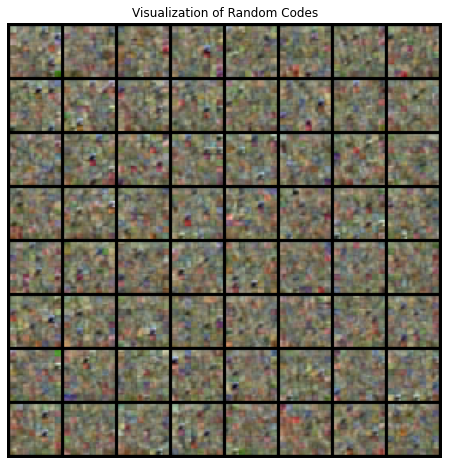

In [17]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))

### Step 7. Play with average vectors

In [ ]:
def get_avg_code(dataset, class_idx, model):


#dataset = torchvision.datasets.CIFAR10(root='./data',transform=torchvision.transforms.ToTensor())
print(train_dataset.class_to_idx)
idx = get_indices(train_dataset, 8)
dog_loader = DataLoader(train_dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(idx))
idx = get_indices(train_dataset, 2)
bird_loader = DataLoader(train_dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(idx))


model.eval()

#with torch.no_grad():
#    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
#    generated_images = decoder(noise)
    
bird_list = []
    
for batch_idx, (x, _) in enumerate(tqdm(bird_loader)):
    
    x = x.to(DEVICE)
    
    z = encoder(x)
    
    z_quantized, commitment_loss, codebook_loss, perplexity = codebook(z)
    
    bird_list.append(z)
    
    bird_images = decoder(z_quantized)
    
    #x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
    #print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
    
birdpile = torch.stack(bird_list)
avg_bird_code = torch.mean(birdpile, dim=0)
z_quantized, _, _, _ = codebook(avg_bird_code)
avg_bird_image = decoder(z_quantized)

draw_sample_image(avg_bird_image[0], "Reconstructed images")